# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 

**Данные:** набор фотографий людей с указанием возраста.

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Загрузка данных

In [2]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
datagen = ImageDataGenerator(validation_split = 0.25)

datagen_flow = datagen.flow_from_dataframe(
    labels_df, 
    '/datasets/faces/final_files', 
    x_col='file_name',
    y_col='real_age',
    target_size=(150,150),
    batch_size=16,
    class_mode=None,
    seed=12345
)

Found 7591 validated image filenames.


Размер нашей выборки 7591 изображение с готовыми метками.

## Исследовательский анализ данных

Построим график распределения возраста в выборке.

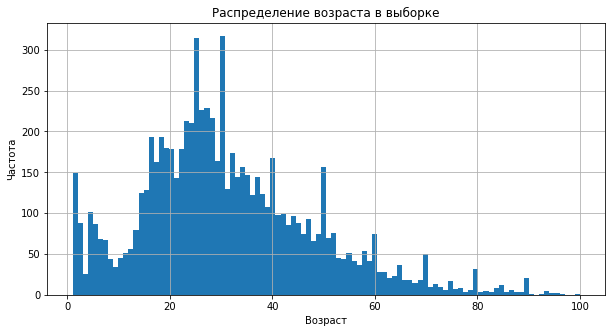

In [4]:
labels_df['real_age'].hist(bins=100, figsize=(10,5))

plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возраста в выборке')
plt.show();

Самый часто встречаемый возраст около 25 и 30 лет. Чаще всего встречается возраст приблизительно 22-27. Реже всего посещают магазин люди старше 80 лет. Чем старше человек, тем реже он посещает магазин.

Примечательно, что имеются пики среди детей в возрасте до 10 лет, скорее всего в камеру попадают дети на руках у родителей, а также дети, рядом с родителями в момент покупки и те, кому родители доверили провести покупку самостоятельно.

Посмотрим как устроен датасет, для этого напечатаем несколько фотографий.

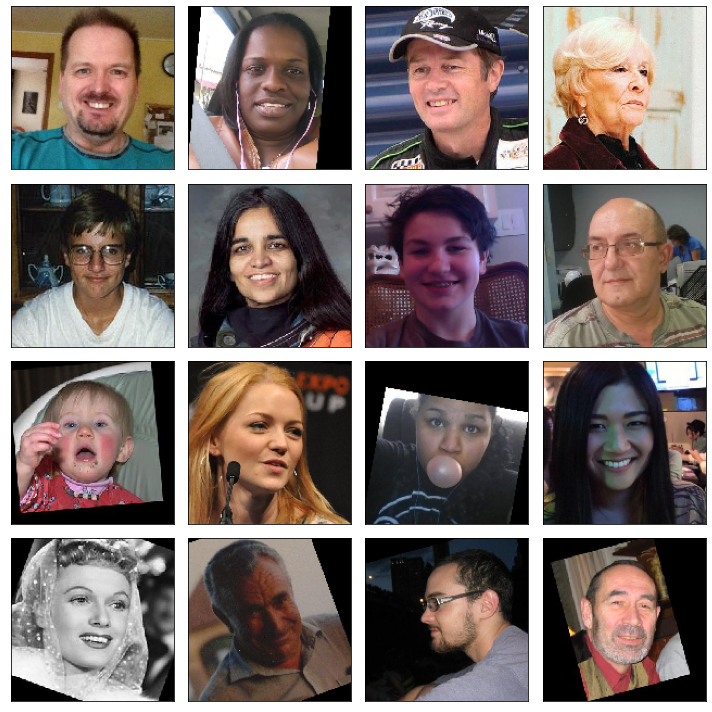

In [5]:
features = next(datagen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow((features[i]).astype(np.uint8))
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Обратим внимание, что фотографии уже прошли предобработку. Очевидно, что фотографии поворачивают, чтобы достичь вертикального положение лица, также фото центрируются так, чтобы лицо (примерно нос) находились ровно посередине изображения, также очевидно, что фото детей скорее всего увеличены.

Выводы: предварительная обработка изображений выполнена системой заранее, можно обойтись без аугментации.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels_df = pd.read_csv(path + '/labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255
    )

    train_datagen_flow = datagen.flow_from_dataframe(
        labels_df, 
        path + '/final_files', 
        x_col='file_name',
        y_col='real_age',
        target_size=(150,150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
        
    return train_datagen_flow
    
    
def load_test(path):
    labels_df = pd.read_csv(path + '/labels.csv')
    
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255
    )

    test_datagen_flow = datagen.flow_from_dataframe(
        labels_df, 
        path + '/final_files', 
        x_col='file_name',
        y_col='real_age',
        target_size=(150,150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
        
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
                    
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(loss='mean_squared_error', 
                  optimizer=Adam(lr=0.0001), metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=7,
               steps_per_epoch=None, validation_steps=None):
                
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
               
    model.fit(train_data,   
          validation_data=test_data,
          batch_size=batch_size,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2, epochs=epochs)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/7
2025-05-02 11:21:31.149591: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-02 11:21:31.497181: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 56s - loss: 261.9377 - mae: 11.5640 - val_loss: 757.8325 - val_mae: 22.5960
Epoch 2/7
178/178 - 40s - loss: 65.3311 - mae: 6.1765 - val_loss: 623.2619 - val_mae: 19.8840
Epoch 3/7
178/178 - 41s - loss: 30.8747 - mae: 4.3079 - val_loss: 400.2666 - val_mae: 14.9769
Epoch 4/7
178/178 - 41s - loss: 18.5061 - mae: 3.3298 - val_loss: 130.7286 - val_mae: 8.5351
Epoch 5/7
178/178 - 41s - loss: 13.2279 - mae: 2.8091 - val_loss: 85.2749 - val_mae: 6.9479
Epoch 6/7
178/178 - 47s - loss: 10.1197 - mae: 2.3965 - val_loss: 73.4979 - val_mae: 6.4217
Epoch 7/7
178/178 - 45s - loss: 9.9569 - mae: 2.3762 - val_loss: 79.2766 - val_mae: 6.5766
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 79.2766 - mae: 6.5766

```

## Анализ обученной модели

Метрика mae модели равна 6.58, что удовлетворяет поставленным условиям. Отметим, что необходимой метрики можно было добиться за 5-7 эпох (количество эпох можно сократить).

Модель была построена со следующими параметрами:
- отсутствие аугментации
- размер батча = 32
- за основу была взята модель ResNet50 с весами imagenet без верхушки
- к модели добавлено 2 слоя:
    - GlobalAveragePooling2D
    - плотный слой с 1 нейроном и функцией активации relu
- в качестве функции потерь использовалась mse
- в качестве оптимизатора алгорим Адам со скоростью обучения 0.0001
- в качестве метрики модели использовалась mae
- модель обучалась на 7 эпохах
- итоговая метрика mae = 6.58